In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle (3).json': b'{"username":"soumyarm92","key":"f3afd38d4a6747d95c9445103f43adb0"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d kazanova/sentiment140
!unzip sentiment140.zip

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sentiment140.zip
replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: training.1600000.processed.noemoticon.csv  


In [5]:
import pandas as pd

df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1',header=None)
df = df[df[0].isin([0, 4])]
df = df[[0,5]]
df.columns = ['sentiment', 'text']

df = df.copy()
df['sentiment'] = df['sentiment'].map({0:0, 4:1})

In [6]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [7]:
import re

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    return text.lower().strip()

df['text'] = df['text'].apply(clean_text)

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

X = pad_sequences(sequences, maxlen=max_len)
y = df['sentiment'].values

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense

model=Sequential()
model.add(Embedding(input_dim=max_words,output_dim=128,input_length=max_len))
model.add(LSTM(64,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_len))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.fit(X_train[:100000], y_train[:100000],
          validation_data=(X_test[:10000], y_test[:10000]),
          epochs=3, batch_size=128)

Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 186s 233ms/step - accuracy: 0.7155 - loss: 0.5446 - val_accuracy: 0.7793 - val_loss: 0.4636
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 199s 230ms/step - accuracy: 0.8074 - loss: 0.4200 - val_accuracy: 0.7835 - val_loss: 0.4544
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 177s 227ms/step - accuracy: 0.8252 - loss: 0.3813 - val_accuracy: 0.7864 - val_loss: 0.4613


In [12]:
# accuracy test on test data
loss, accuracy = model.evaluate(X_test[:10000], y_test[:10000])
print(f"Test Accuracy: {accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.7913 - loss: 0.4532
Test Accuracy: 78.64%


In [15]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_probs = model.predict(X_test[:10000])
y_pred_classes = (y_pred_probs > 0.5).astype(int).reshape(-1)

print(classification_report(
    y_test[:10000],
    y_pred_classes,
    target_names=["Negative", "Positive"]
))

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step
              precision    recall  f1-score   support

    Negative       0.78      0.80      0.79      5004
    Positive       0.79      0.78      0.78      4996

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



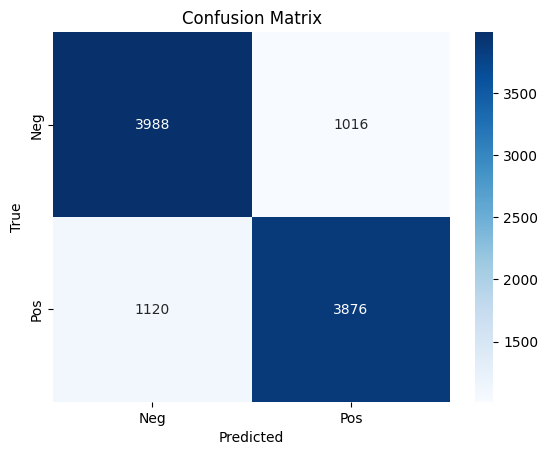

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_test[:10000], y_pred_classes)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=["Neg", "Pos"], yticklabels=["Neg", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [17]:
def predict_sentiment(text):
    text = clean_text(text)
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded)[0][0]
    return 'Positive' if pred > 0.5 else 'Negative'

In [25]:
print(predict_sentiment("I hate this!"))
print(predict_sentiment("It's okay, I guess."))
print(predict_sentiment("I love this so much!"))
print(predict_sentiment("Dumbass!"))
print(predict_sentiment("I love bikes!"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Positive


In [30]:
print(predict_sentiment("I like car!"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Positive
